# Create Gaussian random fields with lya survey geometry to compute $C_{\ell}(k)$
- [x] generate GRFs with Lya bias and beta
- [-] draw skewers through box
- [x] FFT each skewer and construct $\delta_{2D}$ matrix
    - [ ] do discrete version where multiplication of $\exp(i\mathbf(k)\mathbf{\chi})$
- [x] matrix of shape: (N_qso x N_kbins), so that in row i: ($\delta_F(k_0), \dots,\delta_F(k_N)$)
- [ ] compute $$a_{\ell m}(\mathbf{k}) = \sum_j^{N_q} \delta_{2D}(x,y,z,k_i)Y_{\ell m}^{\ast}(x,y,j)$$
- [ ] compute $$\hat{C}_{\ell}(k_i) = \texttt{hp.alm2cl}(a_lm(k_i))$$
- [ ] compare to theory 

In [1]:
%matplotlib inline
import numpy as np
from matplotlib_params_file import *
import healpy as hp
from numba import jit

# test class

## Theory power spectrum for Gaussian random field

In [2]:
my_bias = 1.0
my_beta = 1.5
my_redshift = 2.334
boxsize=1380.
Ncell = 512
aniso_bool = True

In [3]:
import make_GRF as GRF
# Set seed
np.random.seed(100)

grf = GRF.GaussianRandomField(N=Ncell, L=boxsize, bias = my_bias,beta = my_beta, redshift=my_redshift)
p0, p2, p4 = grf.get_multipoles(grf.pk_lin[0,:])

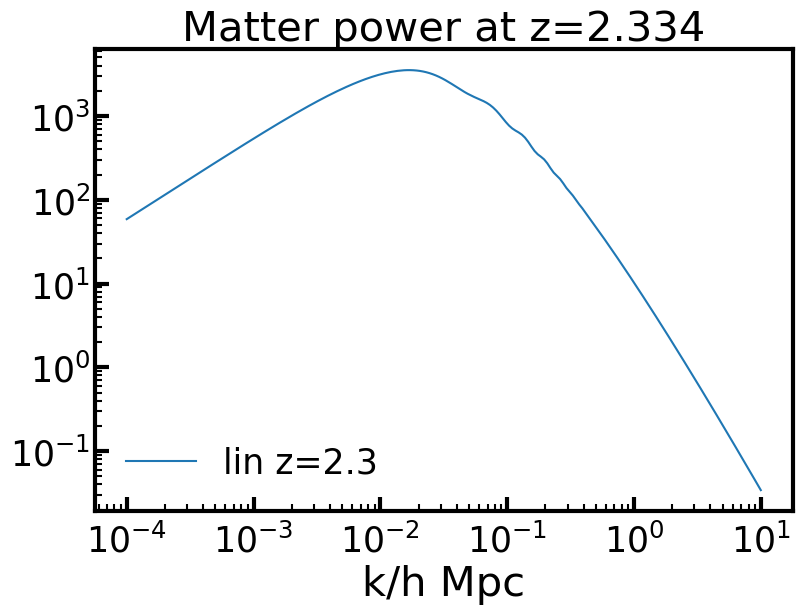

In [4]:
plt.figure(figsize=(9,6))
for i, (redshift, line) in enumerate(zip([grf.z],['-','--'])):
    plt.loglog(grf.kh_lin, grf.pk_lin[i,:], ls = line)
#plt.plot(kh_lin, Plin(kh_lin), 'C2-.')
plt.xlabel('k/h Mpc');
plt.legend(['lin z={:1.1f}'.format(grf.z), 'nbodykit Plin'], loc='lower left');
plt.title('Matter power at z=%s'%grf.z);


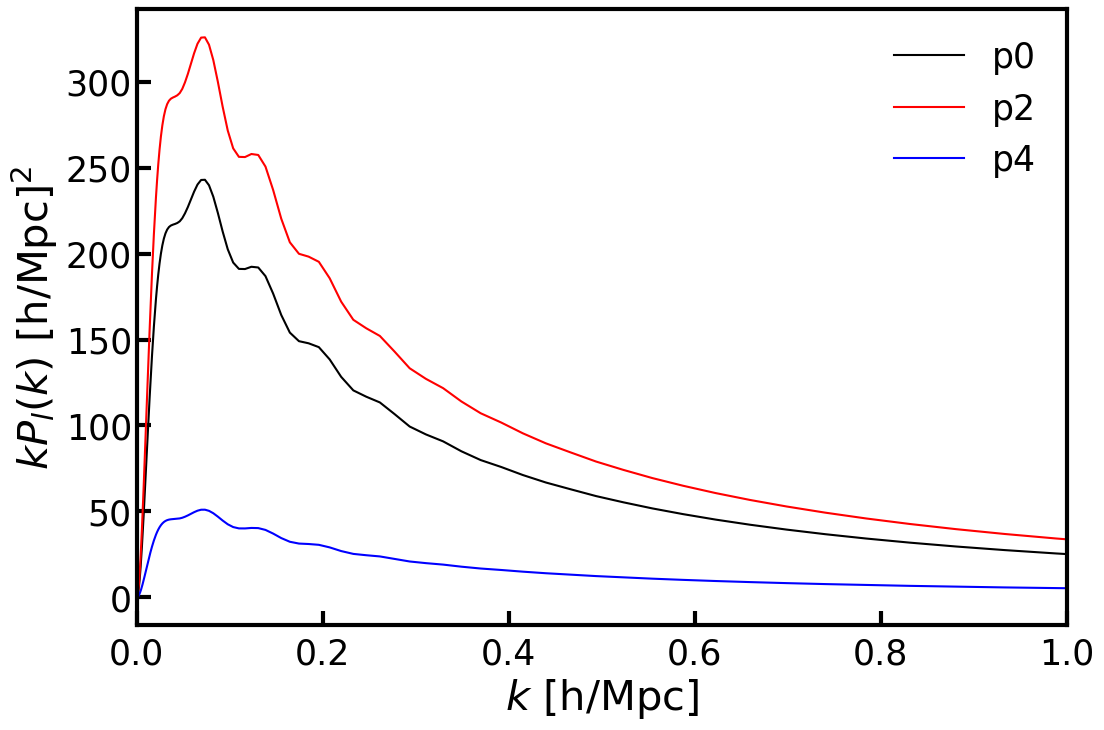

In [5]:
plt.plot(grf.kh_lin,grf.kh_lin*p0, 'k-', label='p0')
plt.plot(grf.kh_lin,grf.kh_lin*p2, 'r-', label='p2')
plt.plot(grf.kh_lin,grf.kh_lin*p4, 'b-', label='p4')
plt.xlabel(r'$k$ [h/Mpc]')
plt.ylabel(r'$kP_l(k)$ [h/Mpc]$^2$')
plt.xlim(0, 1);plt.legend();plt.show()

### Define power spectrum functions

In [12]:
kfft = grf.kfft

@jit(nopython=True)
def compute_mu3d(n):
    print('compute mu = k_los / |k|')
    mu  = np.ones((n,n,n))
    for i in range(n):
        for j in range(n):
            for l in range(n):
                kx=kfft[i]
                ky=kfft[j]
                kz=kfft[l]
                k_sum=np.sqrt(kx**2.0 + ky**2.0 + kz**2.0) # module of distance of origin to compute P(k)
                mu[i,j,l]=kz/(1e-10+k_sum) # angle to z axis
    return mu

@jit(nopython=True)
def get_ks3d(L, n):
    kk  = np.zeros((n,n,n))
    for i in range(n):
        for j in range(n):
            for l in range(n):
                kx=kfft[i]
                ky=kfft[j]
                kz=kfft[l]
                k_sum=np.sqrt(kx**2.0 + ky**2.0 + kz**2.0) # module of distance of origin to compute P(k)
                kk[i,j,l]=k_sum
    return kk


@jit(nopython=True)
def get_amplitudes3d(L, n, Pk, beta, mu):
    areal = np.zeros((n,n,n))
    aim = np.zeros((n,n,n))
    for i in range(n):
        for j in range(n):
            for l in range(np.int32(n/2+1)):
            #for l in range(n):
                pk = Pk[i,j,l]
                if (i==0 or i==np.int32(n/2)) and (j==0 or j==np.int32(n/2)) and (l==0 or l==np.int32(n/2)):
                    areal[i,j,l] =  np.random.normal(0., np.sqrt(pk/2.)) * ( 1. + beta * (mu[i,j,l])**2)
                    aim[i,j,l]   = 0 # real value for k=0 and Nyquist frequency at i,j,l = N/2
                else:
                    areal[i,j,l] =  np.random.normal(0., np.sqrt(pk/2.)) * ( 1. + beta * (mu[i,j,l])**2)
                    aim[i,j,l]   =  np.random.normal(0., np.sqrt(pk/2.)) * ( 1. + beta * (mu[i,j,l])**2) #1./np.sqrt(2) * --> no need for this factor
                    areal[(n-i)%n][(n-j)%n][(n-l)%n] = areal[i,j,l]
                    aim[(n-i)%n][(n-j)%n][(n-l)%n]   = -aim[i,j,l]
    a = areal + 1.0j*aim
    return a #(h/Mpc)**3

@jit(nopython=True)
def compute_amplitudes3d(L, n, Pk, bias, beta, aniso):
    print('Include anisotropies', aniso)
    if aniso:
        mu = compute_mu3d(n)
    else:
        mu  = np.zeros((n,n,n))
        beta = 0.
    print('bias', bias)
    print('beta', beta)
    print('mu', mu[:2,:2,:2].ravel())
    return bias * get_amplitudes3d(L, n, Pk, beta, mu) #(h/Mpc)**3

def density_field(a, L, n, d=3):
    #dimension d=3
    print('Transforming amplitudes to density field')
    boxvol = float(L)**d
    pix    = (float(L)/float(n))**d
    dens   = np.fft.ifftn(a) * boxvol ** (1./2.) / pix
    #dens *= 1./np.sqrt(2*np.pi)**d
    print('dens:',np.mean(dens), np.min(dens), np.max(dens))
    #assert(np.max(abs(np.imag(dens)))<1e-10, 'Density field should be entirely real')
    return np.real(dens)


### Compute amplitudes and k 
- $P_F(k, \mu, z) = b_F(z)^2 (1+\beta_F(z)\mu^2)^2 P_{L}(k)$, thus, for the amplitudes compute $\delta_F \propto b * (\delta_m + \beta \mu^2 \delta_m)$
- coadd both boxes

In [ ]:
# Compute all wave vectors
all_ks_3d = get_ks3d(boxsize, Ncell)

# Interpolate power spectrum for all wave vectors
pk_all = grf.plin(all_ks_3d)


In [20]:
# set seed 
np.random.seed(100)

# compute isotropic box (no beta!)
amplitudes_iso         = compute_amplitudes3d(boxsize, Ncell, pk_all, bias=my_bias, beta=0., aniso=False)
amplitudes_squared_iso = np.real(amplitudes_iso*np.conj(amplitudes_iso))

#compute density field from amplitudes
dens_iso = density_field(amplitudes_iso, boxsize, Ncell)
# set seed 
np.random.seed(100)

amplitudes_aniso       = compute_amplitudes3d(boxsize, Ncell, pk_all, bias=my_bias, beta=my_beta, aniso=True)
amplitudes_squared_tot   = np.real(amplitudes_aniso*np.conj(amplitudes_aniso))

#compute density field from amplitudes
dens = density_field(amplitudes_aniso, boxsize, Ncell)


Include anisotropies False
bias 1.0
beta 0.0
mu [0. 0. 0. 0. 0. 0. 0. 0.]
Transforming amplitudes to density field
dens: (3.9879771091791e-06+0j) (-4.881446684469726+0j) (4.9875412286402385+0j)
Include anisotropies True
compute mu = k_los / |k|
bias 1.0
beta 1.5
mu [0.         0.99999998 0.         0.70710677 0.         0.70710677
 0.         0.57735026]
Transforming amplitudes to density field
dens: (-7.058830574499208e-06+0j) (-7.691102479002027+0j) (7.796231100994261+0j)


## Compute power spectrum 
- Spherically average amplitudes squared in k-shells


In [26]:
@jit(nopython=True)
def compute_Pk(n, amplitudes_squared):
    Phat = np.zeros(bins)
    Phat2 = np.zeros(bins)
    Phat4 = np.zeros(bins)
    k_eff = np.zeros(bins)
    counts = np.zeros(bins) # initialize counts of mode
    totcounts=0
    for i in range(n):
        for j in range(n): 
            for l in range(n):
                totcounts+=1
                kx=kfft[i]
                ky=kfft[j]
                kz=kfft[l]
                k_sum=np.sqrt(kx**2.0 + ky**2.0 + kz**2.0) # module of distance of origin to compute P(k)
                mu   = kz/(1e-10+k_sum) # angle to z axis
                l2mu = (3.*mu**2.-1.)/2.
                l4mu = (35.*mu**4.-30.*mu**2. + 3.)/8.

                for m in range(bins):
                    if (k_sum>=k_bins[m] and k_sum<k_bins[m+1]): # check if in bin
                        Phat[m]  += amplitudes_squared[i,j,l] # measure monopole
                        Phat2[m] += amplitudes_squared[i,j,l]*(2.*2.+1.)*l2mu # measure quadrupole
                        Phat4[m] += amplitudes_squared[i,j,l]*(2.*4.+1.)*l4mu # measure hexadecapole
                        k_eff[m] += k_sum
                        counts[m]+= 1.

    # normalization 
    Phat /=counts # P over number of modes
    Phat2/=counts
    Phat4/=counts
    k_eff/=counts

    print(sum(counts))
    print(totcounts)
    print(N**3)
    return k_eff, Phat, Phat2,Phat4, counts,totcounts


In [25]:
# compute power spectra
k_eff_iso, Phat_iso, Phat2_iso, Phat4_iso,counts,totcounts = compute_Pk(Ncell, amplitudes_squared_iso)
k_eff_tot, Phat_tot, Phat2_tot,Phat4_tot, counts,totcounts = compute_Pk(Ncell, amplitudes_squared_tot)
# normalize power spectrum
k_diff = grf.k_bins[1:]-grf.k_bins[:-1]
dk=grf.k_bins[1]-grf.k_bins[0]

V   = boxsize ** 3 # volume of box
V_k = 4.0 * np.pi * (grf.k_bins[1:]**3.0-grf.k_bins[:-1]**3.0)/3.0 # 

V_f=grf.k_f**3.0

N_k = V_k / V_f

norm_const = V / (Ncell**6) # P=1/V <\delta \delta>, but each \delta needs units of volume V/N_c^3

# normalize P(k)
#Phat_iso_final = Phat_iso*norm_const
#Phat2_iso_final = Phat2_iso*norm_const
### compute theory


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'grf':[0m [1m[1mCannot determine Numba type of <class 'make_GRF.GaussianRandomField'>[0m
[1m
File "../../../../../../../tmp/ipykernel_2078144/3058812925.py", line 3:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m

In [ ]:
# theory power spectrum isotropic --> beta = 0
p0_iso, p2_iso, p4_iso = grf.get_multipoles(bias=my_bias, beta=0.,      pk=pk_lin[0,:])


NameError: name 'k_eff_tot' is not defined

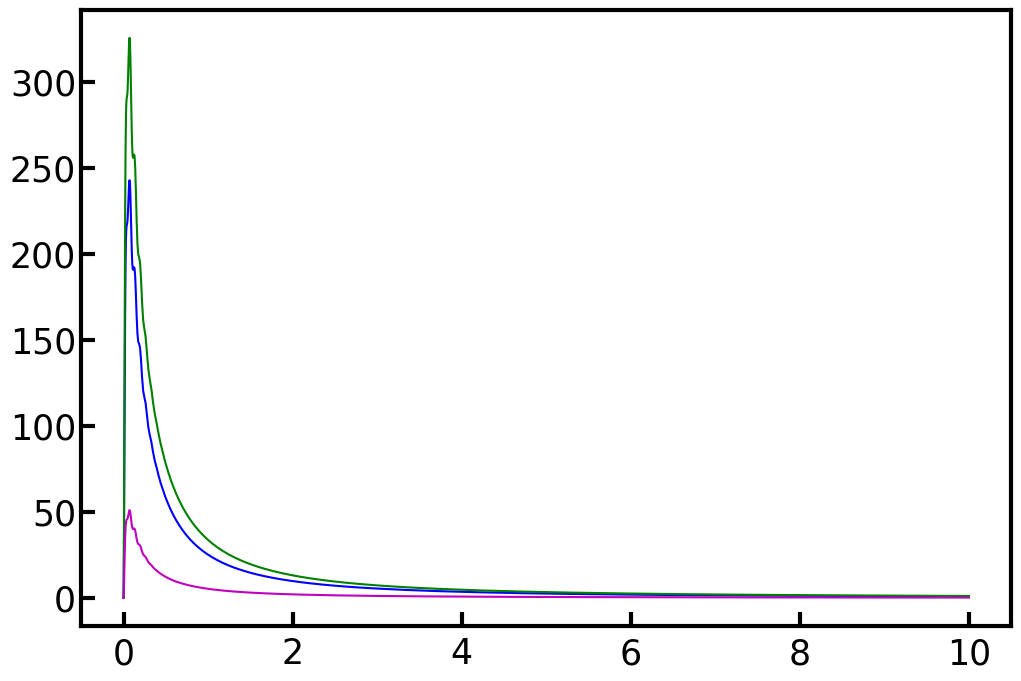

In [23]:
### compare theory to measurement

plt.plot(grf.kh_lin, grf.kh_lin*p0, 'b-', label=r'$\ell=0$ (aniso)')
plt.plot(grf.kh_lin, grf.kh_lin*p2, 'g-', label=r'$\ell=2$ (aniso)')
plt.plot(grf.kh_lin, grf.kh_lin*p4, 'm-', label=r'$\ell=4$ (aniso)')
plt.plot(grf.kh_lin,grf.kh_lin*Phat_tot, 'bo--',label=r'$\hat{P}_{\ell=0}^{\mathrm{aniso}}(k)$')
plt.plot(grf.kh_lin, grf.kh_lin*abs(Phat2_tot), 'go--',label=r'$\hat{P}_{\ell=2}^{\mathrm{aniso}}(k)$')
plt.plot(grf.kh_lin, grf.kh_lin*abs(Phat4_tot), 'mo--',label=r'$\hat{P}_{\ell=4}^{\mathrm{aniso}}(k)$')
plt.xlabel(r'$k\,[h$Mpc$^{-1}]$')
plt.ylabel(r'$k\,P_\ell(k)\,[h^{-2}$Mpc$^{2}]$')
plt.legend(ncol=2);plt.xlim(0., 0.5);
#plt.ylim(0., 320)
plt.show()


## Sample skewers
- Note that we apply a shift along the z axis. This is necessary to ensure that the $\mu$ angle is with respect to the z-axis
- (HIPSTER natively computes $\mu$ with respect to the combined line-of-sight; $(\vec{r}_i+\vec{r}_j)/2$)
- We just use a small number of skewers here for testing


In [11]:
if add_rsd:
    iso_str = '_aniso'
    amplitudes         = compute_amplitudes3d(L, N, pk_all, bias=my_bias, beta=my_beta, aniso=True)
else:
    iso_str = ''
    # compute isotropic box (no beta!)
    print('isotropic box')
    amplitudes         = compute_amplitudes3d(L, N, pk_all, bias=my_bias, beta=0., aniso=False)

amplitudes_squared = np.real(amplitudes*np.conj(amplitudes))
#compute density field from amplitudes
dens = density_field(amplitudes, L, N)

Include anisotropies True
compute mu = k_los / |k|
bias 1.0
beta 1.5
mu [0.         0.99999998 0.         0.70710677 0.         0.70710677
 0.         0.57735026]
Transforming amplitudes to density field
dens: (-9.518719734653198e-06+0j) (-7.486884865100343+0j) (7.450080737515289+0j)


### extract full length skewers through the box

In [12]:
shift_box = True
shift = 5e+3 if shift_box else 0.

## only choose one slice for angular power spectrum

In [13]:
coords = np.meshgrid(*[np.linspace(0,L,N) for _ in range(3)])
Nskew = int(1e3)
Nskew = int(5e5)
inds = np.unique(np.random.randint(0,N,size=(Nskew,2)),axis=0)
Nskew = len(inds)
print("N_skew = %d / %d"%(Nskew,N**2))

# DELTA + 1
dens_lya = 1.+dens[inds[:,0],inds[:,1],:]
skewer_field = dens_lya.ravel()
# take skewers in z-direction
print("Displacing box by %.3e"%shift)
all_x = coords[0][inds[:,0],inds[:,1],:].ravel()+shift
all_y = coords[1][inds[:,0],inds[:,1],:].ravel()+shift
all_z = coords[2][inds[:,0],inds[:,1],:].ravel()+shift
all_tid = (np.ones(N)[None,:]*np.arange(len(inds))[:,None]).ravel()
all_w_rand = np.ones_like(all_x,dtype='float')
all_w_gal  = np.asarray(skewer_field,dtype='float')
all_hpx = np.zeros_like(all_x,dtype='float')

N_skew = 223353 / 262144
Displacing box by 5.000e+03


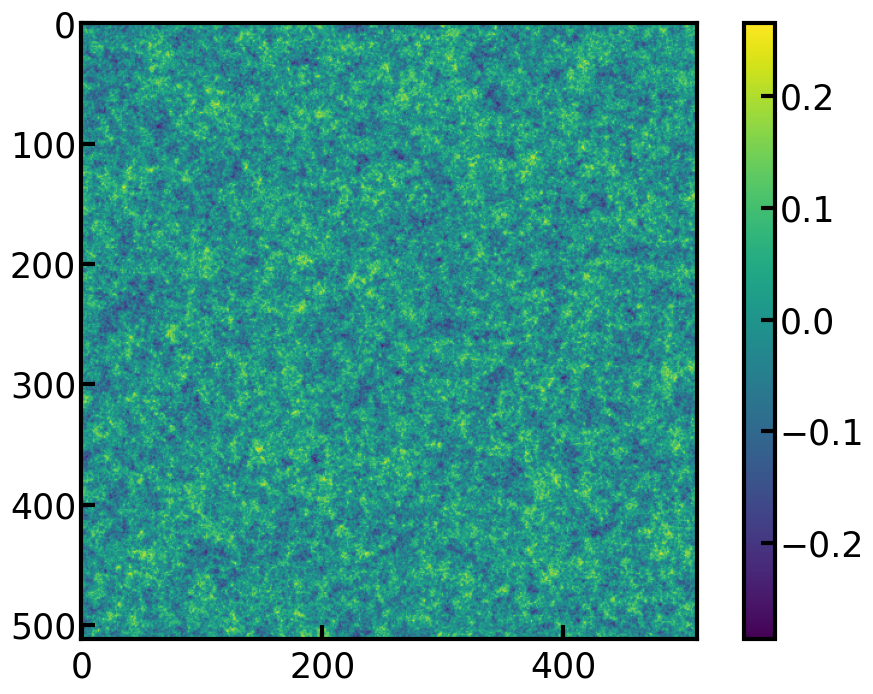

In [14]:
plt.imshow(dens.mean(2));plt.colorbar();plt.show()

In [15]:
3

3

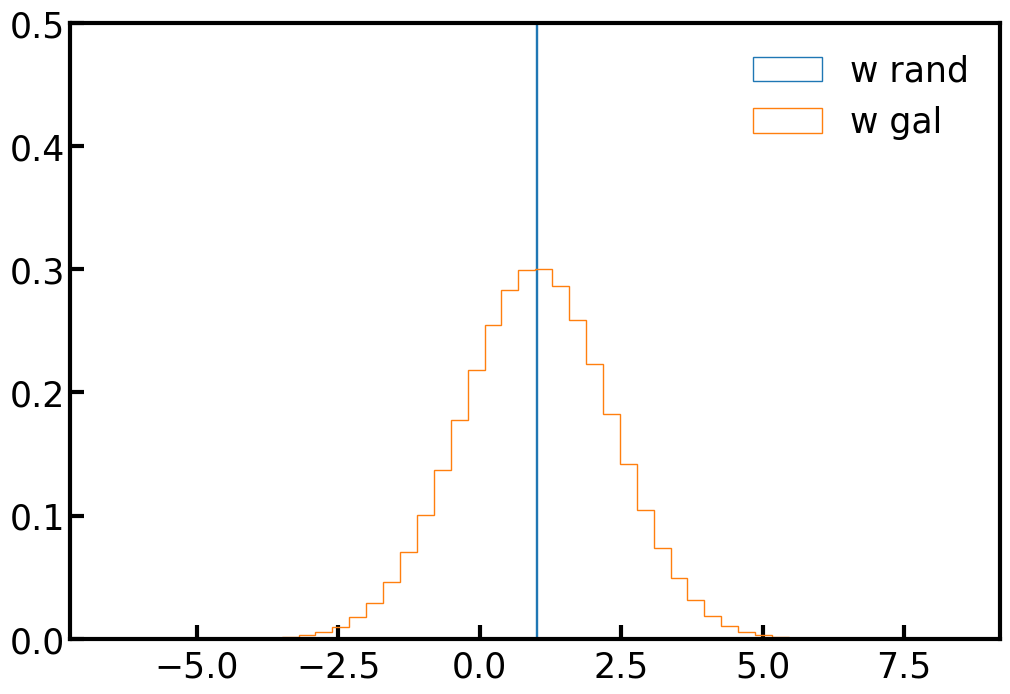

In [16]:
### Plot distribution of weights
plt.hist(all_w_rand,density=True,histtype='step', bins=50, label='w rand');
plt.hist(all_w_gal,density=True, histtype='step',bins=50, label='w gal');
plt.ylim(0., 0.5);plt.legend()
plt.show()

# #### Visually check if skewers are taken through box
# plt.title('Skewers')
# plt.scatter(all_x[:],all_y[:],s=0.1);plt.xlabel('x');plt.ylabel('y');plt.show()
# plt.scatter(all_x[:],all_z[:],s=0.1);plt.xlabel('x');plt.ylabel('z');plt.show()
# plt.scatter(all_y[:],all_z[:],s=0.1);plt.xlabel('y');plt.ylabel('z');plt.show()

## 2D case
- [ ] project 3D field along LOS (z-axis)
- [ ] compute Ra,Dec in rad for {x,y} positions
- [ ] compute theory C_ell for my GRFs

In [17]:
do_plots = True


In [18]:
def coord_transform(x,y,z):
    # Convert the X,Y,Z coordinates into Ra,Dec,comoving_distance
    # Shamelessly stolen from astropy/nbodykit
    xsq = x ** 2.
    ysq = y ** 2.
    zsq = z ** 2.

    com_dist = (xsq + ysq + zsq) ** 0.5
    s = (xsq + ysq) ** 0.5

    # convert to degrees
    phi = np.arctan2(y, x)
    theta = np.arctan2(s, z)
    # wrap lon to [0,360]
    #lon = np.mod(lon-360., 360.)
    
    return com_dist, theta, phi

In [19]:
dens[:,:,0]

array([[-0.17756833, -1.58949081,  0.40540685, ..., -0.49507613,
        -1.10845956,  1.23949894],
       [ 0.64711823, -0.23438676, -0.67323624, ..., -0.50958499,
         0.05210227, -0.54325985],
       [ 1.90152346,  1.50000772, -0.02011264, ..., -0.78003659,
        -0.89204108,  0.21872587],
       ...,
       [-0.56079668,  0.38388871,  1.49185388, ..., -2.57056816,
        -1.55446032,  0.1657892 ],
       [-0.71699868, -1.36194478, -0.97960144, ..., -0.09061154,
        -1.69597985,  0.36061042],
       [-1.53918468, -1.26473008, -0.5299587 , ..., -1.32769889,
        -1.39956264, -1.00481398]])

In [ ]:
3

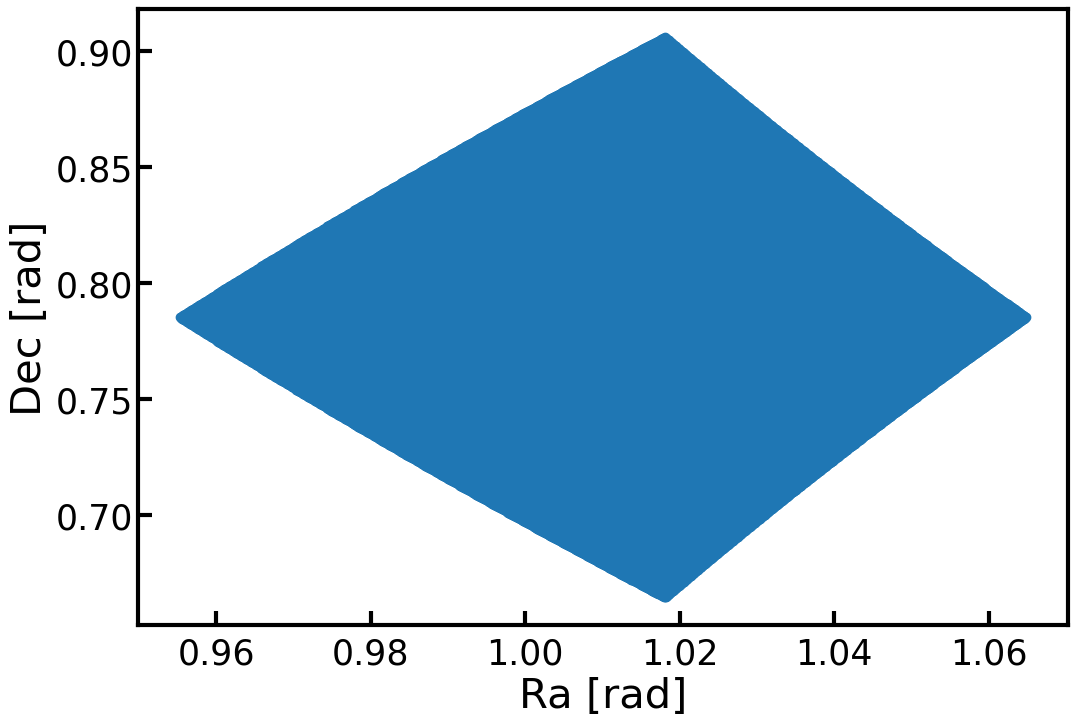

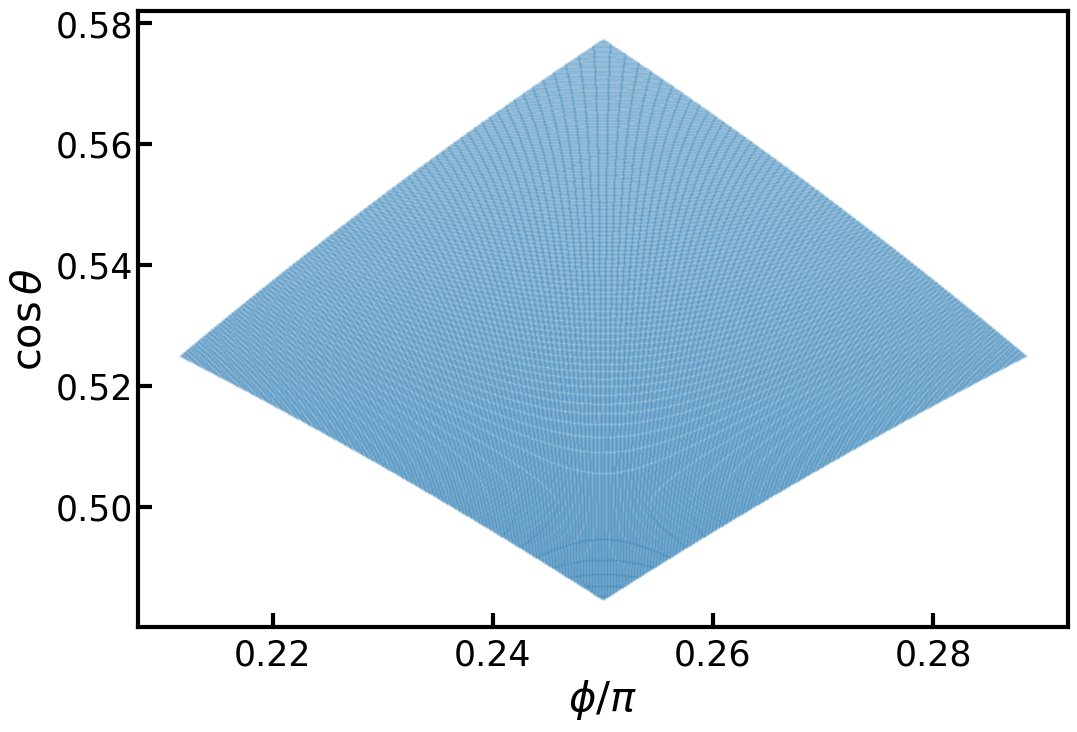

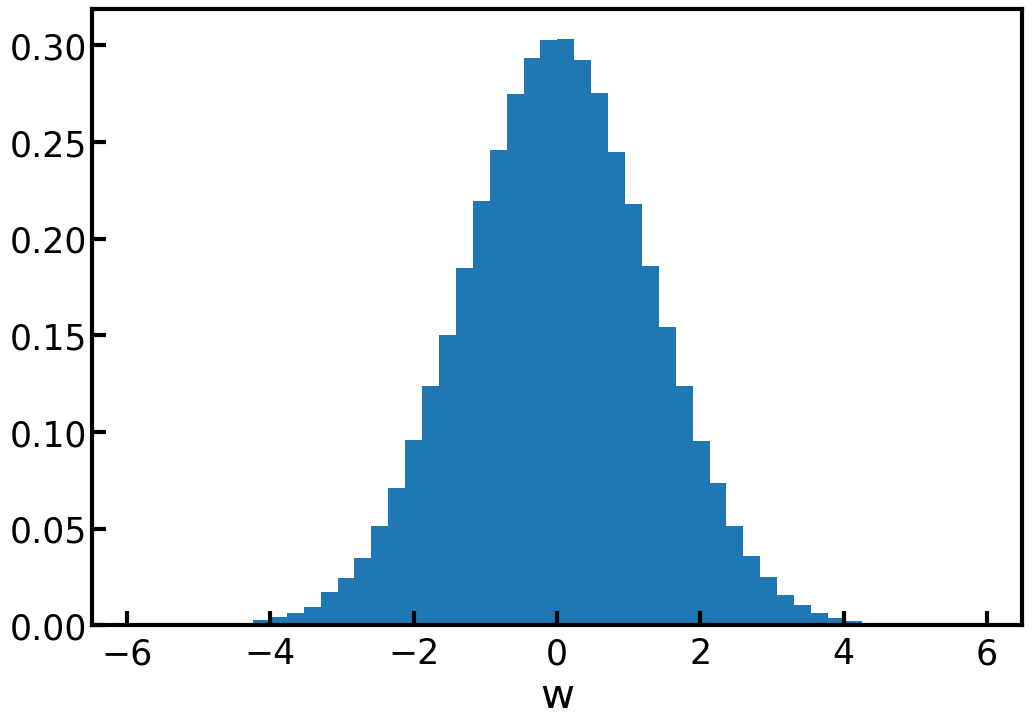

In [ ]:
idx_slice=0

#mean of the box and use all pixels first 
w = dens[:,:,idx_slice].ravel()
x = coords[0][:,:,idx_slice].ravel() + shift
y = coords[1][:,:,idx_slice].ravel() + shift
z = coords[2][:,:,idx_slice].ravel() + shift

# now convert cartesian to sky coordinates

# Convert coordinates to spherical coordinates
_,Ra,Dec = coord_transform(x,y,z);
tdata,pdata,wdata = Ra, Dec, w
trand,prand,wrand = Ra, Dec, np.ones_like(w)

if do_plots: 
    plt.figure();plt.scatter(tdata,pdata);plt.xlabel('Ra [rad]');plt.ylabel('Dec [rad]');plt.show()
    plt.figure();plt.scatter(pdata/np.pi,np.cos(tdata), s=1,c='C0',alpha=0.1,label='Rand',rasterized=False);plt.xlabel(r'$\phi/\pi$');plt.ylabel(r'$\cos\theta$');plt.show()
    plt.hist(wdata, bins=50, density=True);plt.xlabel('w');plt.show()    

# # matrix of my skewers in (no z bins x no QSOs)

# mask_tid = np.unique(all_tid, return_index=True)[1]
# # the {x,y} corredinates of my box are:
# x, y, w = all_x[mask_tid], all_y[mask_tid], dens_lya.mean(1)
# # now convert cartesian to sky coordinates

# # Convert coordinates to spherical coordinates
# # assume that the box is at redshift 2.4
# box_distance = results.comoving_radial_distance(2.4)
# _,Ra,Dec = coord_transform(x,y,np.ones_like(x)*box_distance);
# tdata,pdata,wdata = np.deg2rad(Ra), np.deg2rad(Dec),w
# trand,prand,wrand = np.deg2rad(Ra), np.deg2rad(Dec),np.ones_like(w)

# if do_plots: 
#     plt.figure();plt.scatter(tdata,pdata);plt.xlabel('Ra [rad]');plt.ylabel('Dec [rad]');plt.show()
#     plt.hist(wdata, bins=50, density=True);plt.xlabel('w');plt.show()    

### use directSHT to compute $C_{ell}$

In [21]:
import sys
%env JAX_ENABLE_X64=True
#
sys.path.insert(0, '/global/homes/r/rmvd2/lya_Cl/directsht-lya/')
from sht.sht                import DirectSHT
from sht.mocks              import LogNormalMocks
from sht.mask_deconvolution import MaskDeconvolution

env: JAX_ENABLE_X64=True


CUDA backend failed to initialize: Found cuBLAS version 120201, but JAX was built against version 120304, which is newer. The copy of cuBLAS that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [22]:
# Set up an sht instance.
Nl   = 500
Nx   = 2*Nl
xmax = 3./4.
#
sht= DirectSHT(Nl,Nx,xmax)
#
# We'll want to go to higher lmax in W_l to do mode-decoupling
buffer_ells = 64
sht_randoms = DirectSHT(Nl+buffer_ells,Nx,xmax)
#
print("For general, Direct SHT has Nl=",sht.Nell,", Nx=",Nx," and xmax=",xmax)
print("For randoms, Direct SHT has Nl=",sht_randoms.Nell,", Nx=",Nx," and xmax=",xmax)

: 

In [ ]:
# plt.scatter(tdata, pdata)

fig,ax = plt.subplots(1,1,figsize=(6,6))
#
ax.scatter(pdata/np.pi,np.cos(tdata),s=1,c='C1',alpha=0.1,label='Data',rasterized=False)
ax.set_xlabel(r'$\phi/\pi$')
ax.set_ylabel(r'$\cos\theta$')
plt.tight_layout()

In [ ]:
# Get harmonic coefficients for the data and measure raw Cls
hdat = sht(tdata,pdata,wdata)
hdcl = hp.alm2cl(hdat)
#
# Do the same for the randoms.
hran = sht(tdata,pdata,wrand)
hrcl = hp.alm2cl(hran)
#
# and for the difference of data and randoms:
hdif = hp.alm2cl(hdat-hran)
print("hatC in range [{:e},{:e}]".format(np.min(hdif[1:]),np.max(hdif[1:])))
#

In [ ]:
plt.loglog(np.arange(1,hdif.size),hdif[1:])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\hat{C}_\ell$')
plt.savefig('./plots/window_convolved_Cell.pdf', bbox_inches='tight')

In [ ]:
# Calculate the angular power spectrum of the randoms
#
hran_for_wl = sht_randoms(tdata,pdata,wrand)
#  After subtracting shot noise, this gives us the
#  angular power spectrum of the window function 
# sn = 1.0/float(nrand)/(4*np.pi) * float(ndata)**2

# ignore shot noise for now

wl = hp.alm2cl(hran_for_wl)# - sn
plt.loglog(wl,label='raw')
#
plt.xlabel(r'$\ell$')
plt.ylabel(r'$W_\ell$')
plt.legend()
plt.savefig('./plots/harmonic_window.pdf', bbox_inches='tight')

In [19]:
# Calculate the angular power spectrum of the randoms
#
hran_for_wl = sht_randoms(trand,prand,wrand)
#  After subtracting shot noise, this gives us the
#  angular power spectrum of the window function 
#sn = 1.0/float(nrand)/(4*np.pi) * float(ndata)**2
wl = hp.alm2cl(hran_for_wl)# - sn

Sorting & digitizing took  0.2303152084350586  seconds.
Reshaping took  0.19787907600402832  seconds.
Precomputing vs took  4.33543062210083  seconds.
Computing alm's took  3.0050528049468994  seconds.


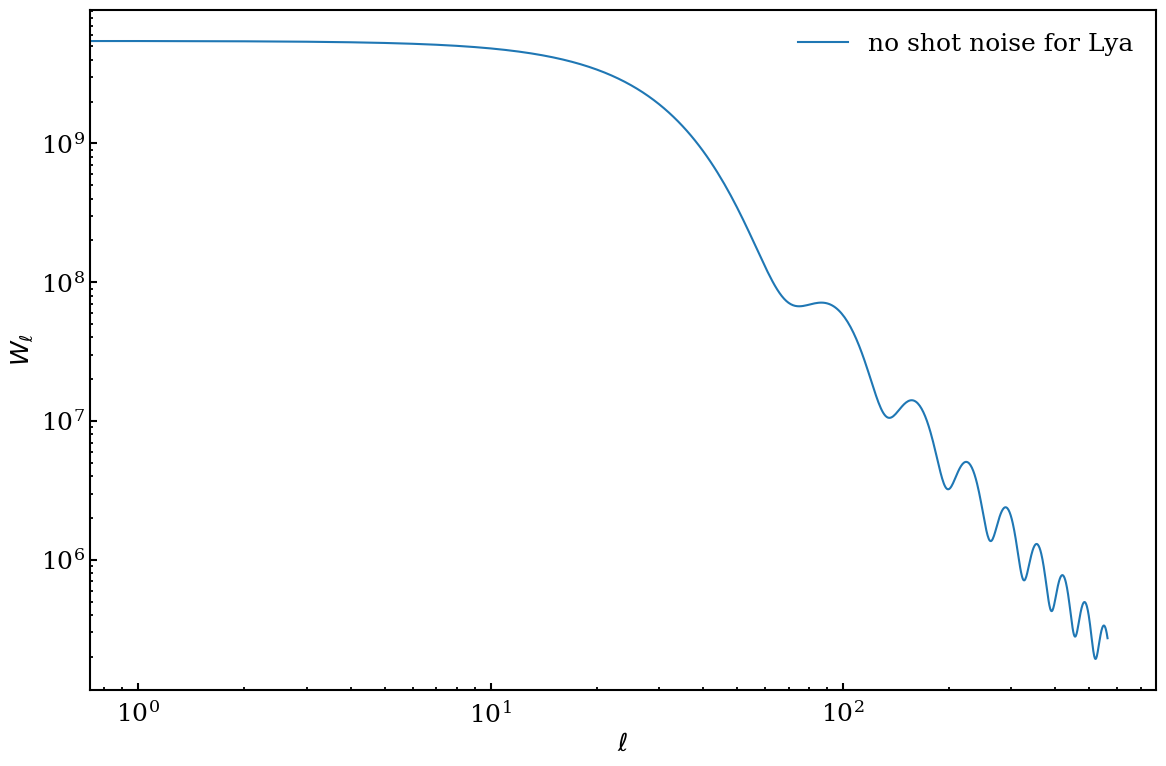

In [26]:
plt.loglog(wl   ,label='no shot noise for Lya')
#
plt.xlabel(r'$\ell$')
plt.ylabel(r'$W_\ell$')
plt.legend()
plt.tight_layout()
#plt.savefig('harmonic_window.pdf')

In [21]:
# Initialize an instance of the MaskDeconvolution. This will let us deconvolve
# the mask-induced mode-coupling of the pseudo-Cls, convolved the theory to
# enable apples-to-apples comparisons, and provide binning functionality
%time MD = MaskDeconvolution(Nl+buffer_ells,wl)
#
NperBin = 2**5
bins    = MD.binning_matrix('linear',0,NperBin)
Mbl     = MD.window_matrix(bins)
# Look at the sums over ell.
print("\nRow sums of Mbl:")
print(Mbl.sum(axis=1))

Precomputing Wigner 3j symbols...
Computing the mode-coupling matrix...
CPU times: user 2min 38s, sys: 1.31 s, total: 2min 39s
Wall time: 2min 39s

Row sums of Mbl:
[1.00179074 0.99860135 1.00172524 0.99861549 1.00210195 0.99813094
 1.00309934 0.99685666 1.00545079 0.99348681 1.01179188 0.98321627
 1.03203911 0.94681321 1.10854473 0.79573807 1.46867479]


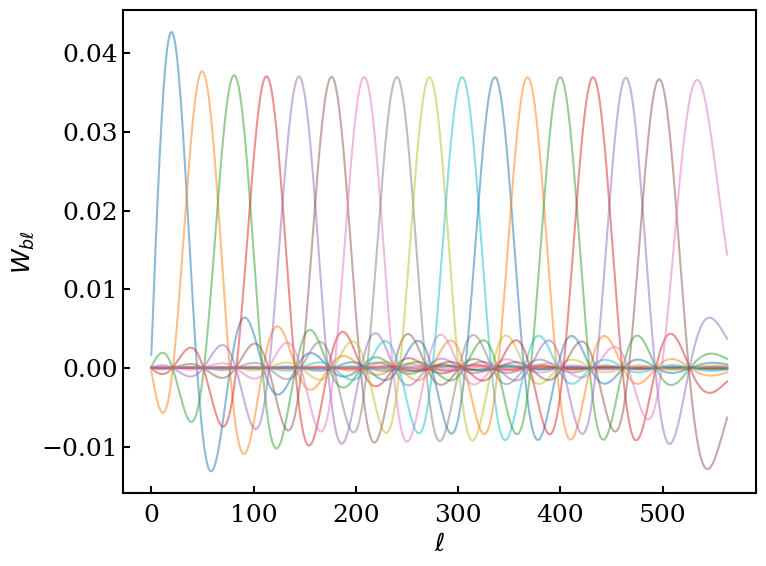

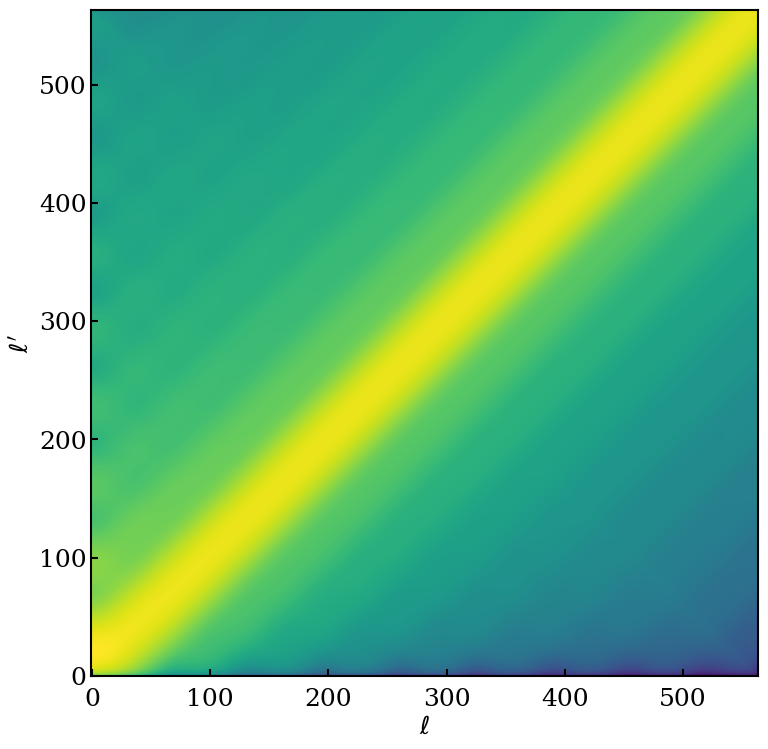

In [22]:
# Plot the matrix:
fig,ax = plt.subplots(1,1,figsize=(8,6))
for i in range(Mbl.shape[0]):
    ax.plot(Mbl[i,:],alpha=0.5,label='Bin '+str(i))
#ax.legend(bbox_to_anchor=(1.1,1.0))
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$W_{b\ell}$')
plt.tight_layout()
plt.savefig('harmonic_wbl.pdf')
#
# and plot the mode-coupling matrix itself.
fig,ax = plt.subplots(1,1,figsize=(8,8))
mode_coupling = np.log( 1+MD.Mll.clip(0,1e30) )
ax.imshow(mode_coupling.T,origin='lower')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\ell^\prime$')
plt.tight_layout()
#plt.savefig('harmonic_mll.pdf')

Sorting & digitizing took  0.020892858505249023  seconds.


Reshaping took  0.043482065200805664  seconds.
Precomputing vs took  3.5472617149353027  seconds.
Computing alm's took  2.302950620651245  seconds.
Sorting & digitizing took  0.013175010681152344  seconds.
Reshaping took  0.02912139892578125  seconds.
Precomputing vs took  3.3599634170532227  seconds.
Computing alm's took  2.136126756668091  seconds.
hatC in range [2.875258e+05,5.456217e+09]


Text(0, 0.5, '$\\hat{C}_\\ell$')

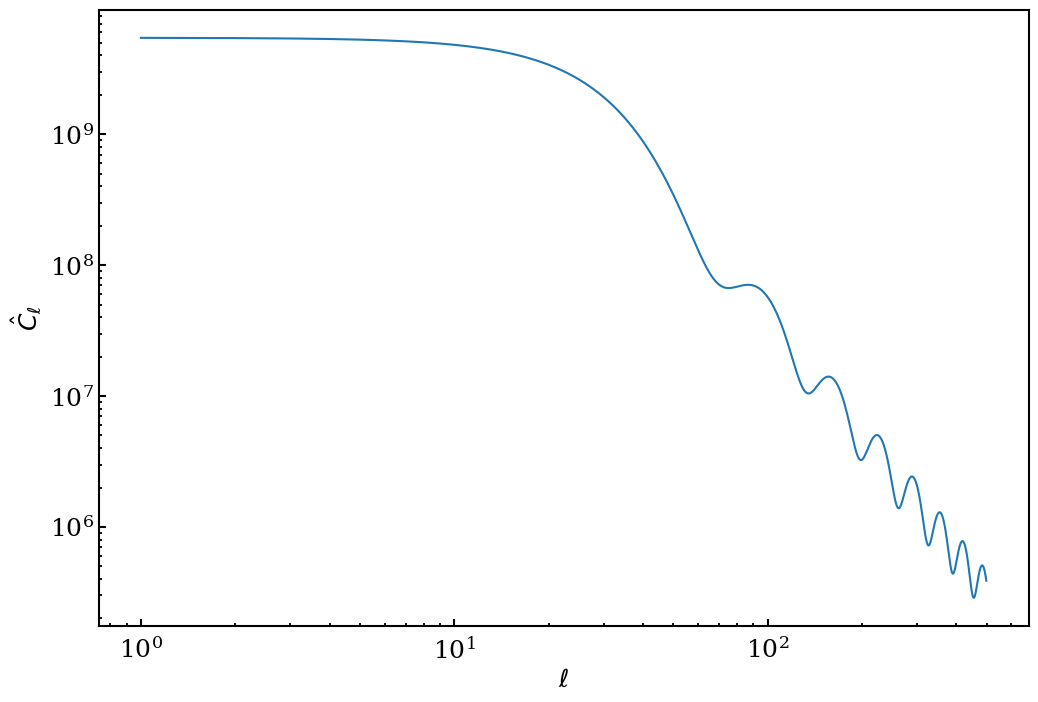

In [23]:
# Get harmonic coefficients for the data and measure raw Cls
hdat = sht(tdata,pdata,wdata)
hdcl = hp.alm2cl(hdat)
#
# Do the same for the randoms.
hran = sht(trand,prand,wrand)
hrcl = hp.alm2cl(hran)
#
# and for the difference of data and randoms:
hdif = hp.alm2cl(hdat-hran)
print("hatC in range [{:e},{:e}]".format(np.min(hdif[1:]),np.max(hdif[1:])))
#
plt.loglog(np.arange(1,hdif.size),hdif[1:])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\hat{C}_\ell$')

In [24]:
# Now work out the binned and decoupled pseudo-spectrum.
# The first Ndiscard bins are removed because they have
# support to very low ell and the last bins because
# they have support past lmax
Ndiscard = 2
binned_ells,hdif_decoupled = MD(hdif,bins)
binned_ells,hdif_decoupled = binned_ells[Ndiscard:-Ndiscard],hdif_decoupled[Ndiscard:-Ndiscard]

In [25]:
print(binned_ells)
print(hdif_decoupled)

[ 79.5 111.5 143.5 175.5 207.5 239.5 271.5 303.5 335.5 367.5 399.5 431.5
 463.5]
[ 1.63145542e-03 -6.64907943e-04  2.89772825e-04 -1.33774124e-04
  6.40848201e-05 -3.23537069e-05  1.67282023e-05 -8.86764650e-06
  4.90123516e-06 -2.89816883e-06  1.75120738e-06 -1.06479183e-06
  7.19153704e-07]


NameError: name 'cl_theory' is not defined

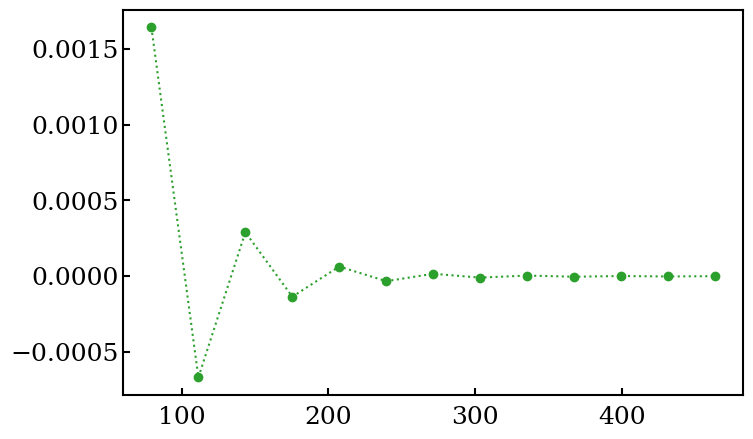

In [29]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(binned_ells,hdif_decoupled,'o:',color='C2',label='Direct')
#
# Compare to the theory convolved with the bandpower window function -- we
# expect some differences due to sample variance, but they shouldn't be huge.
clt_conv = np.dot(Mbl,cl_theory[:Mbl.shape[1]])
ax.plot(binned_ells, clt_conv[Ndiscard:-Ndiscard],'o:',color='C1',label='Theory')
#
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\tilde{C}_\ell$')
#
ax.legend()
plt.tight_layout()
#plt.savefig('harmonic_tildeC.pdf')

# Fourier transform along each LOS 
- the box has dimensions $(N \times N \times N)$ where $N$=512. 
- we choose $\textit{parallel}$ along z 
    - FFT each skewer


In [132]:
# dens_lya - weights describing the box: wgal = w*(1+delta_F= = 1*(1+delta_F)
# approx. 1000 skewers

# data matrix is dens_lya 
delta_3D = dens_lya
Nqso, Npix = delta_3D.shape
print(f'delta_3d shape: {delta_3D.shape}: (Nqso = {Nqso}, Npix = {Npix})')

# construct exp(ik chi)) matrix
# k is the k vector
# chi is the comoving distance
Delta_chi = all_z.max() - all_z.min()
k_f = 2.*np.pi/Delta_chi
k_max = k_f*Npix
print(f'kmax = {k_max:.4f}; k_fundamental = {k_f:.4f}, Nk = {Npix}')
k_grid = np.linspace(k_f, k_max, Npix)
chi_grid = np.unique(all_z)
print(f'kgrid shape = {k_grid.shape}, chi_grid shape = {chi_grid.shape}')
FFT_mat = np.exp(1j*np.outer(k_grid, chi_grid))
print(f'FFT_mat shape = {FFT_mat.shape} (Nk x Npix)')

delta_3d shape: (999, 512): (Nqso = 999, Npix = 512)
kmax = 2.3312; k_fundamental = 0.0046, Nk = 512
kgrid shape = (512,), chi_grid shape = (512,)
FFT_mat shape = (512, 512) (Nk x Npix)


In [117]:
# Reshape delta_3D to have an additional axis at the end
delta_3D_expanded = delta_3D[:, :, np.newaxis]  # Shape: (Nqso, Npix, 1)
print(delta_3D_expanded.shape)

# Reshape delta_3D to have an additional axis at the beginning
FFT_mat_expanded = FFT_mat.T[np.newaxis, :, :]  # Shape: (1, Nk, Npix)
print(FFT_mat_expanded.shape)


(999, 512, 1)
(1, 512, 512)


array([[-0.7151095 -0.69901245j, -0.7064607 -0.70775227j,
        -0.69770509-0.7163851j , ..., -0.73208147-0.68121709j,
        -0.72365019-0.69016694j, -0.7151095 -0.69901245j],
       [ 0.0227632 +0.99974088j, -0.00182656+0.99999833j,
        -0.02641521+0.99965106j, ...,  0.07188655+0.99741282j,
         0.04733919+0.99887887j,  0.0227632 +0.99974088j],
       [ 0.68255314-0.73083596j,  0.70904148-0.70516677j,
         0.73456514-0.67853817j, ...,  0.62682784-0.77915779j,
         0.65513616-0.75551083j,  0.68255314-0.73083596j],
       ...,
       [ 0.46006504-0.88788522j,  0.44911322-0.89347485j,
         0.4380935 -0.89892941j, ...,  0.48175836-0.8763041j ,
         0.4709473 -0.88216135j,  0.46006504-0.88788522j],
       [-0.9496397 +0.31334397j, -0.9496397 +0.31334397j,
        -0.9496397 +0.31334397j, ..., -0.9496397 +0.31334397j,
        -0.9496397 +0.31334397j, -0.9496397 +0.31334397j],
       [ 0.89812771+0.43973472j,  0.89265303+0.45074446j,
         0.8870434 +0.46168604

In [121]:
delta_3D_k = np.dot(FFT_mat_expanded, delta_3D_expanded)

In [122]:
delta_3D_k.shape

(1, 512, 999, 1)

In [ ]:
delta_2D_expanded = delta_3D_expanded * FFT_mat_expanded  # Shape: (Np, Nq, Nk)

In [98]:
def multiply_and_integrate(A, B):
    # Get the shapes of the matrices
    Nq, Np = A.shape
    Np_, Nk = B.shape

    # Check if the matrices can be multiplied
    assert (Np == Np_), "Inner dimensions of matrices do not match"

    # Reshape A to introduce the new axis
    A_reshaped = A[:, :, np.newaxis]
    # Reshape B to introduce the new axis
    B_reshaped = B[np.newaxis, :, :]

    # Multiply A_reshaped with B
    result = np.matmul(A_reshaped, B_reshaped)

    # Integrate along the axis of dimension Np
    integrated_result = np.trapz(result, axis=1)

    return integrated_result

In [100]:
delta_2D_k = multiply_and_integrate(delta_3D, FFT_mat)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 512 is different from 1)